# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
import os
os.sys.path
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


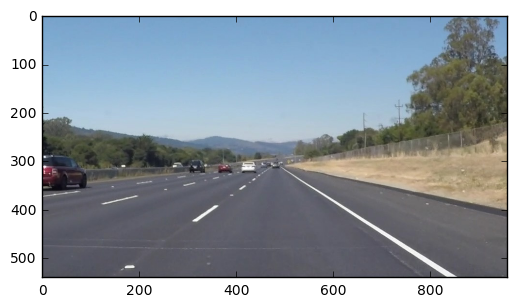

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale_vid(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def tresh(img,MaxVal):
    return cv2.adaptiveThreshold(img,MaxVal,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,13,2)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def sample_wheel(samples,w):
    picked = []
    N=len(samples)
    index = int(random.random() * N)
    beta = 0.0
    mw = max(w)
    for i in range(N):
        beta += random.random() * 2.0 * mw
        while beta > w[index]:
            beta -= w[index]
            index = (index + 1) % N
        [c1,c2,c3,c4]=samples[index]
        picked.append([c1,c2])
        picked.append([c3,c4])
        #print ([samples[index]],w[index])
    #print ("DONE")
    return picked

def draw_lines(img, vertices, lines, color=[255, 0, 0], thickness=12):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    [bottom_left,top_left,top_right,bottom_right]=vertices[0]
    
    
    
    ##Filter m
    left_lines=[]
    left_pairs=[]
    left_lengs=[]
    l_points=[]
    
    right_pairs=[]
    right_lengs=[]
    
    
    low_left=np.tan(np.deg2rad(140))
    high_left=np.tan(np.deg2rad(150))
    low_right=np.tan(np.deg2rad(30))
    high_right=np.tan(np.deg2rad(40))
    ##Check min and max slopes
    total_len=0
    total_len_r=0
    for line in lines:
        for x1,y1,x2,y2 in line:
            m=(y2-y1)/(x2-x1)
            if low_left<m and m<high_left:
                left_lines.append([x1,y1])
                left_lines.append([x2,y2])
                leng=np.sqrt((y2-y1)**2 + (x2-x1)**2)
                total_len+=leng
                left_pairs.append([x1,y1,x2,y2])
                left_lengs.append(leng)
            elif low_right<m and m<high_right:
                leng=np.sqrt((y2-y1)**2 + (x2-x1)**2)
                total_len_r+=leng
                right_pairs.append([x1,y1,x2,y2])
                right_lengs.append(leng)
                #print ("Adding to right: ",[x1,y1,x2,y2])

    
    '''
    #Regresion left
    #print("Left_points:")
    #print(left_lines)
    left_points=np.array(left_lines)
    #Fit returns [(vector normalized in direction of line),(a point in line)]
    [vx,vy,x,y]=cv2.fitLine(left_points,cv2.DIST_L2,0,0.001,0.001)
    m=vy/vx
    #For Y in horizon (see polygon shape 310); X=
    y_top=top_left[1]
    x_top=int(x + (y_top-y)/m)
    #For Y in bottom (540), X=
    y_bottom=bottom_left[1]
    x_bottom=int(x + (y_bottom-y)/m)
    #cv2.line(img, (x_bottom, y_bottom), (x_top, y_top), color, thickness)
    #cv2.line(img, (x_top, y_top), (x_bottom, y_bottom), [0,255,0], thickness)
    #print("Original points:", left_points)
    #print("Regression [m,x,y]",[m],[x_bottom,y_bottom],[x_top,y_top])
    '''
      
    
    
    
        
    #print ("    Total lenght")
    #print (total_len)
    #print ("Longitudes y pesos")
    ##Before regression, weighed pick left
    
    
    w_len=[]
    index=[]
    for i in range (len(left_lengs)):
        w_len.append(left_lengs[i]/total_len)
        '''
        #Disabled for sample wheel
        left_pairs[i].append(left_lengs[i]/total_len)
        '''
        #print([left_pairs[i],w_len[i]])
        index.append(i)
    ############### CHANGE PICK METHOD#########
    #print("seleccionando 20 muestras: ")
    pl_points=sample_wheel(left_pairs,w_len)
    
    
    '''
    ###############OLD PICK
    #Pick_left
    if len(left_pairs)<10:
        for_pick=len(left_pairs)
    else:
        for_pick=int(np.ceil(.8*len(left_pairs)))
    sum_p=0
    picked=np.random.choice(index, size=for_pick, replace=False, p=w_len)
    #print ("Oroginal Data #:   ",index)
    #print ("Picked:  ",picked)
    i=0
    pl_points=[]
    fil_left=[]
    while(sum_p<.8):
        index=picked[i] 
        [c1,c2,c3,c4,w]=left_pairs[index]
        pl_points.append([c1,c2])
        pl_points.append([c3,c4])
        fil_left.append([c1,c2,c3,c4])
        sum_p+=w
        i=i+1
        #If already used 80% of samples and havn´t reached 80% of total lenght of detected, break
        if i>=len(picked):
            sum_p=1.
        #print([c1,c2,c3,c4,w])
     '''
    
    #Regresion left
    #print("Left_points:")
    #print(left_lines)
    left_points=np.array(pl_points)
    #Fit returns [(vector normalized in direction of line),(a point in line)]
    [vx,vy,x,y]=cv2.fitLine(left_points,cv2.DIST_L2,0,0.001,0.001)
    m=vy/vx
    #For Y in horizon (see polygon shape 310); X=
    y_top=top_left[1]
    x_top=int(x + (y_top-y)/m)
    #For Y in bottom (540), X=
    y_bottom=bottom_left[1]
    x_bottom=int(x + (y_bottom-y)/m)
    cv2.line(img, (x_top, y_top), (x_bottom, y_bottom), [139,0,139], thickness)
    
    

###########################################################################
####             Right
###########################################################################

    #Probabilistic Right
    ##Weighted right
    w_len=[]
    index=[]
    for i in range (len(right_lengs)):
        w_len.append(right_lengs[i]/total_len_r)
        #right_pairs[i].append(right_lengs[i]/total_len_r)
        #print([right_pairs[i],w_len[i]])
        index.append(i)
    #print ("Weighted righst: ")
    #print(right_pairs)
    #print("Seleccionando Derecha")
    pr_points=sample_wheel(right_pairs,w_len)
    '''
    #Pick_right
    if len(right_pairs)<10:
        for_pick=len(right_pairs)
    else:
        for_pick=int(np.ceil(.8*len(right_pairs)))
    sum_p=0
    picked=np.random.choice(index, size=for_pick, replace=False, p=w_len)
    #print ("Original Data #:   ",index)
    #print ("Picked Right:  ",picked)
    i=0
    pr_points=[]
    fil_right=[]
    while(sum_p<.8):
        index=picked[i] 
        [c1,c2,c3,c4,w]=right_pairs[index]
        pr_points.append([c1,c2])
        pr_points.append([c3,c4])
        fil_right.append([c1,c2,c3,c4])
        sum_p+=w
        i=i+1
        #If already used 80% of samples and havn´t reached 80% of total lenght of detected, break
        if i>=len(picked):
            sum_p=1.
        #print([c1,c2,c3,c4,w])
    '''

    #Regresion right
    #print ("Right points:")
    #print(fil_right)
    right_points=np.array(pr_points)
    #Fit returns [(vector normalized in direction of line),(a point in line)]
    [vx,vy,x,y]=cv2.fitLine(right_points,cv2.DIST_L2,0,0.001,0.001)
    m=vy/vx
    #For Y in horizon (see polygon shape 310); X=
    y_top=top_right[1]
    x_top=int(x + (y_top-y)/m)
    #For Y in bottom (540), X=
    y_bottom=bottom_right[1]
    x_bottom=int(x + (y_bottom-y)/m)
    cv2.line(img, (x_top, y_top), (x_bottom, y_bottom), [139,0,139], thickness)
    #print("Original points:", left_points)
    #print("Regression [m,x,y]",[m],[x_bottom,y_bottom],[x_top,y_top])
        
    
    ##########################################################################3
    
    ##Print Probabilistic
    

    ##Print lines in right m
    
    for x1,y1,x2,y2 in left_pairs:
        cv2.line(img, (x1, y1), (x2, y2), color=[0,0,255], thickness=1)
    for x1,y1,x2,y2 in right_pairs:
        cv2.line(img, (x1, y1), (x2, y2), color=[0,0,255], thickness=1)
    """
    """        
    '''        
    ##Print filtered
    for x1,y1,x2,y2 in fil_left:
        cv2.line(img, (x1, y1), (x2, y2), color=[0,0,255], thickness=4)
    
    ##Print filtered right
    for x1,y1,x2,y2 in fil_right:
        cv2.line(img, (x1, y1), (x2, y2), color=[0,0,255], thickness=4)
    '''

    

def hough_lines(img, vertices, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img,vertices, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.7, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

Done


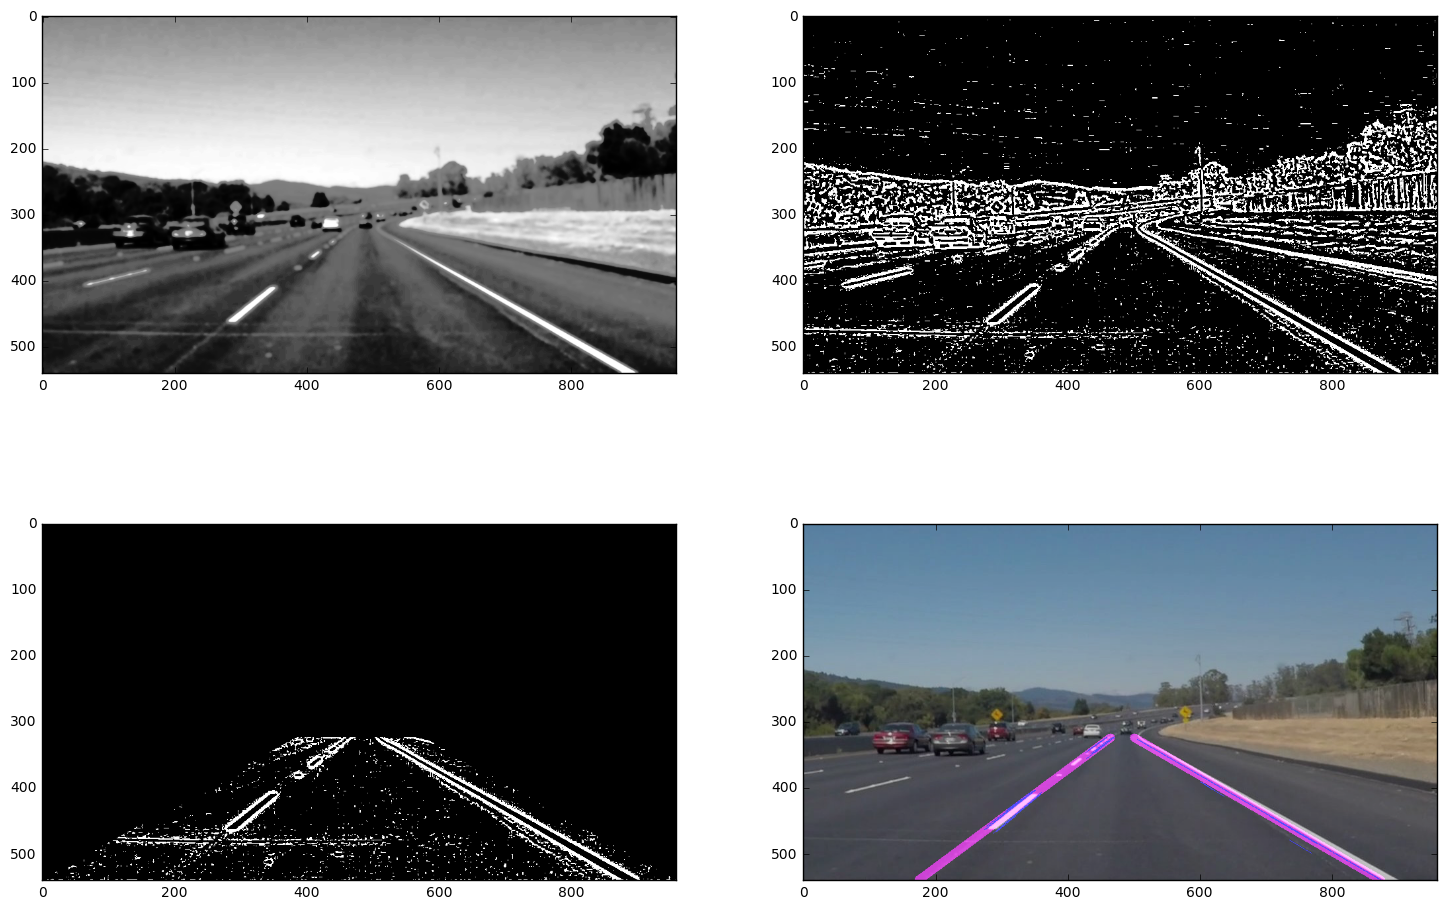

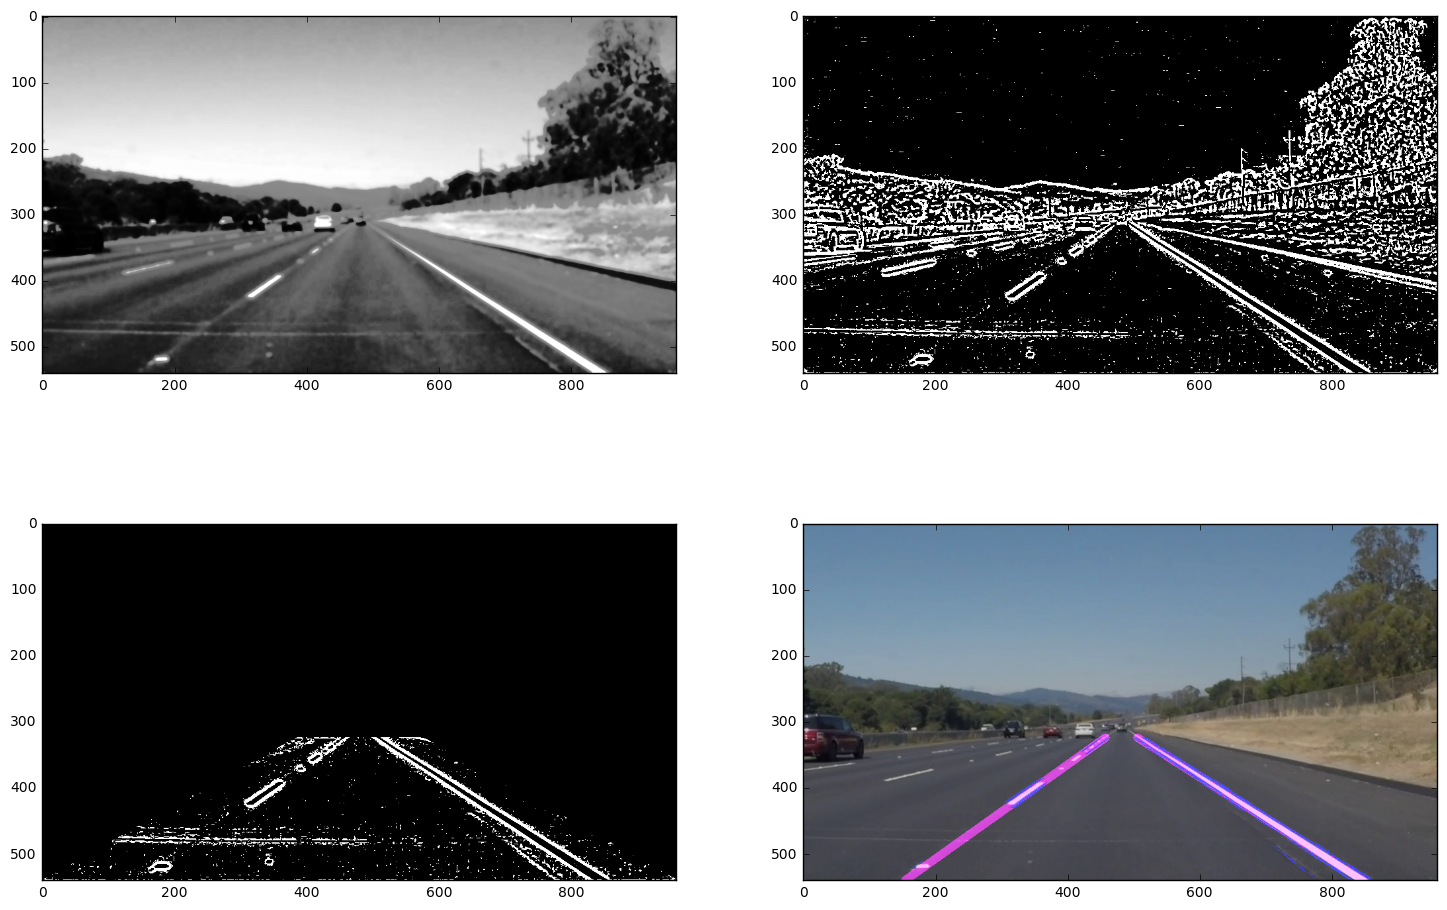

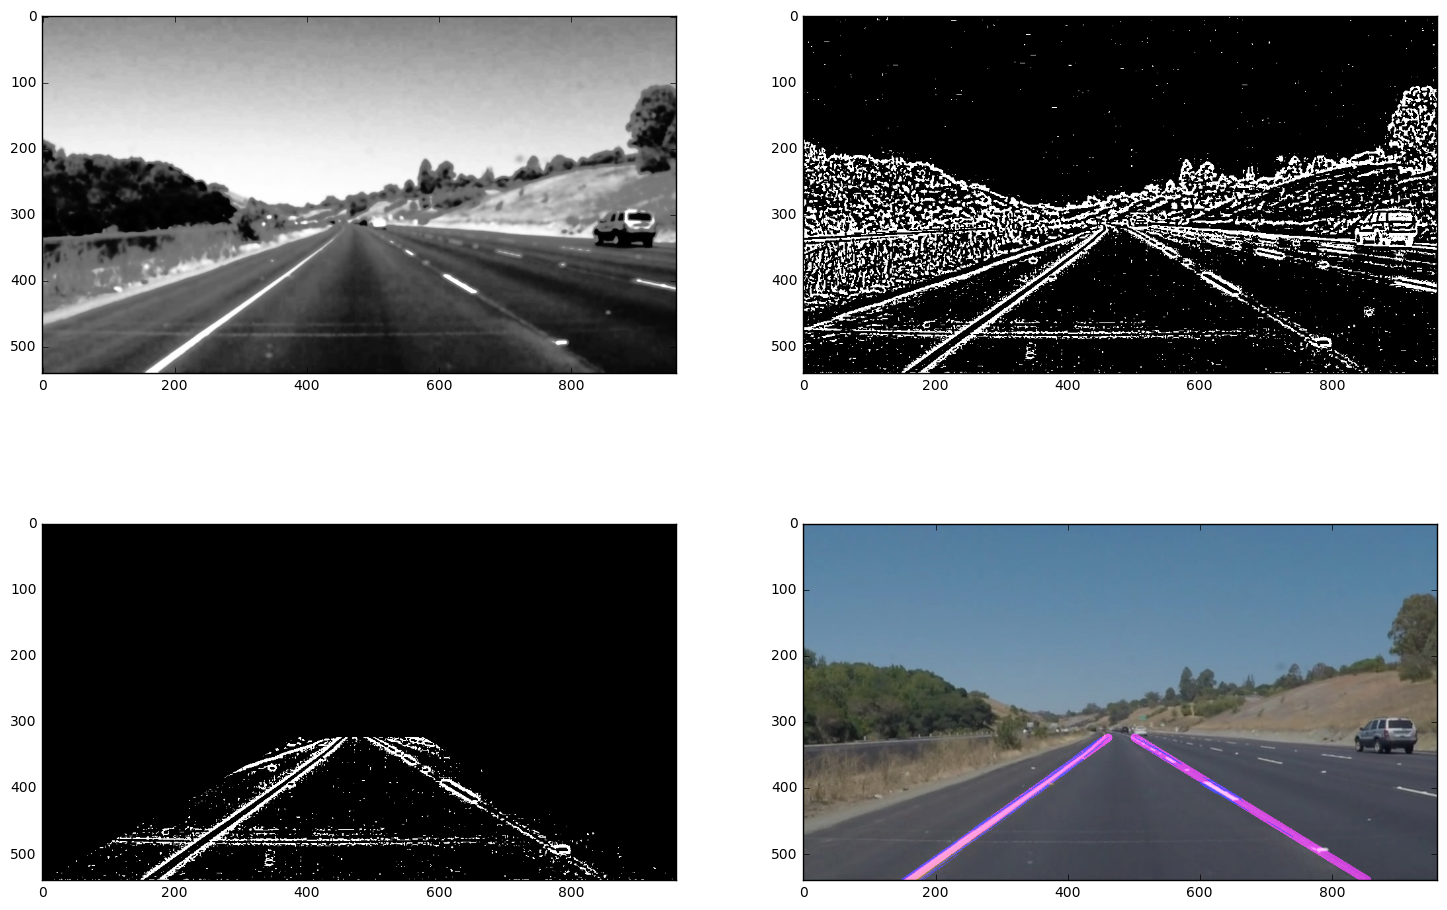

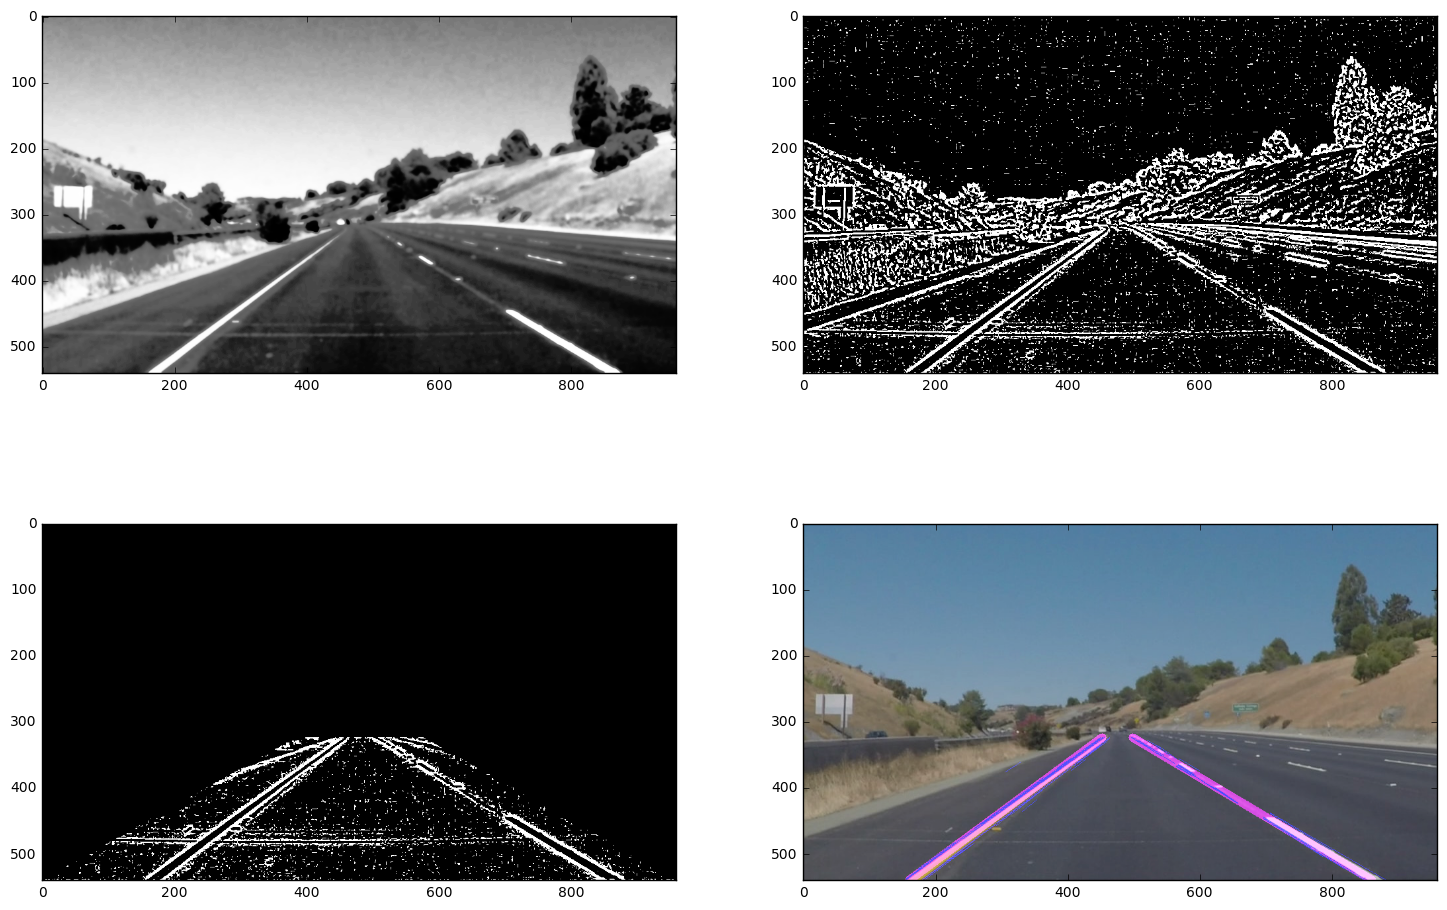

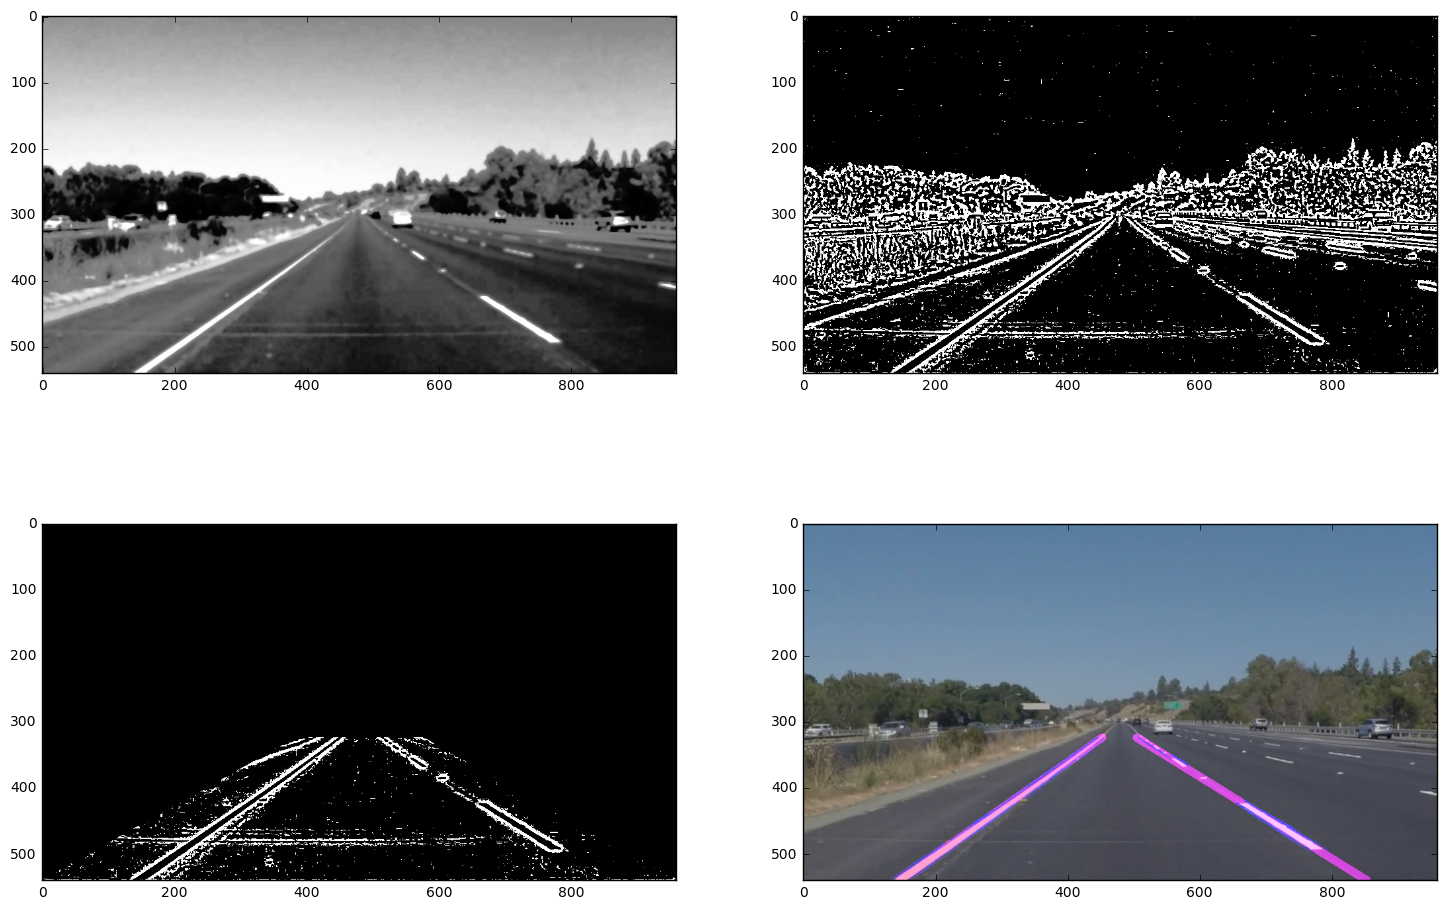

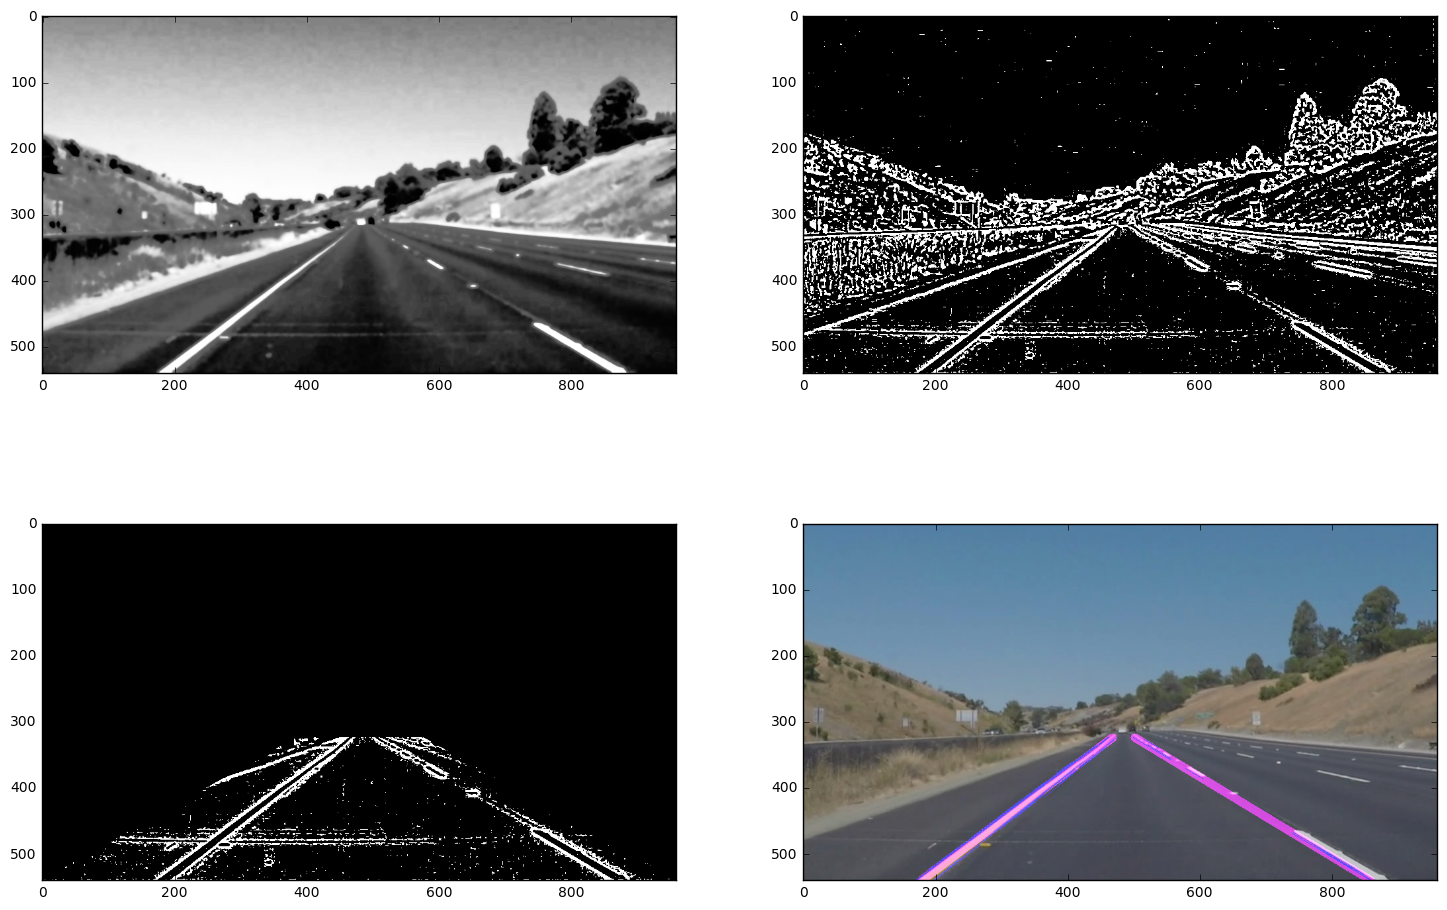

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

#TODO:
#1.-Import images
#2.-Grayscale images
#3.-Blur
#4.-Canny Edge
#5.-Polygon Mask
#6.-Hough space
#7.-Draw Lines
#8.-Save Files

##Aditional: Use Skeletonize or Probabilistic HoughLines
##http://stackoverflow.com/questions/36598897/python-and-opencv-improving-my-lane-detection-algorithm



##Parameters
###Blur
kernel_size=9
###Cany
low_threshold = 200
high_threshold = 250
##Hough Space
rho=1*1
theta=1*(np.pi/180)
threshold=50
min_line_len=20
max_line_gap=1

#1.-Import images
for photogram in os.listdir("test_images/"):
    ##Check for files in dir
    #print ("test_images/"+photogram)
    image = mpimg.imread("test_images/"+photogram)
    
    ysize = image.shape[0]
    xsize = image.shape[1]
    
    shape_bot1=int((1/16)*xsize)
    shape_bot2=int((15/16)*xsize)
    shape_top1=int(.4*xsize)
    shape_top2=int(.6*xsize)
    shape_hor=int(.6*ysize)
#2.-Grayscale images
    gray=grayscale(image)
    
#3.-Blur
    blur=gaussian_blur(gray,kernel_size)
    #Equalize image as to sharpen differences before 
    equ = cv2.equalizeHist(blur)
    
    #plt.figure(figsize=(18,12))
    #plt.subplot(1,2,1)
    #plt.imshow(blur,cmap='gray')
    #plt.subplot(1,2,2)
    #plt.imshow(equ,cmap='gray')
    #plt.savefig("result_images/greys_"+photogram)
    
#4.-Canny Edge
    #edges=canny(blur,low_threshold, high_threshold)
    
    edges_tresh=tresh(gray,120)
    edges=canny(edges_tresh,low_threshold, high_threshold)
    
#5.-Polygon Mask

    
    ##dtype is data interpretation for array 
    imshape=edges.shape
    #vertices = np.array([[(150,540),(450,320),(510,320),(930,540)]],dtype=np.int32)
    vertices = np.array([[(0,ysize),(shape_top1,shape_hor),(shape_top2,shape_hor),(xsize,ysize)]],dtype=np.int32)
    #masked=region_of_interest(edges, vertices)
    masked=region_of_interest(edges_tresh, vertices)
    
#6.-Hough space
    line_img=hough_lines(masked,vertices,rho,theta,threshold,min_line_len,max_line_gap)
    

#7.-Draw Lines
    #post=_img=weighted_img(line_img,image,α=.6, β=1.0, λ=0.0)
    post=weighted_img(line_img,image,α=.8, β=1.0, λ=0.0)

##Output 
    #figsize is 
    plt.figure(figsize=(18,12))
    plt.subplot(2,2,1)
    #plt.imshow(image)
    plt.imshow(equ,cmap='gray')
    plt.subplot(2,2,2)
    #plt.imshow(equ,cmap='gray')
    plt.imshow(edges_tresh,cmap='gray')
    plt.subplot(2,2,3)
    plt.imshow(masked,cmap='gray')
    #plt.imshow(line_img)
    plt.subplot(2,2,4)
    plt.imshow(post)
    
#8.-Save Files
    ##Open CV works in BGR mode, pass to RGB before saving picture
    ##https://carnd-forums.udacity.com/display/CAR/questions/6524093/p1-images-have-the-wrong-color-when-i-save-an-image-using-cv2.imwrite
    plt.savefig("result_images/steps_"+photogram)
    #Save result image
    cv2.imwrite("result_images/post_"+photogram,cv2.cvtColor(post, cv2.COLOR_BGR2RGB))
    
print ("Done")


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    #--Is already an image (?)
    #1.-Grayscale
    #2.-Blur
    #3.-Equalization
    #4.-Canny Edge
    #5.-Mask
    #6.-Hough Space
    #7.-Draw lines
    # you should return the final output (image with lines are drawn on lanes)
    
    ysize = image.shape[0]
    xsize = image.shape[1]
    
    shape_bot1=int((1/16)*xsize)
    shape_bot2=int((15/16)*xsize)
    shape_top1=int(.4*xsize)
    shape_top2=int(.6*xsize)
    shape_hor=int(.6*ysize)
    
    ##Paraeters
    kernel_size=7
    ###Cany
    low_threshold = 200
    high_threshold = 250
    ##Hough Space
    rho=1
    theta=np.pi/180
    threshold=50
    min_line_len=20
    max_line_gap=8
    
    
    #1.-Grayscale
    gray=grayscale_vid(image)
    
    #2.-Blur
    blur=gaussian_blur(gray,kernel_size)
    #result=gray
    
    #3.-Equalization
    equ = cv2.equalizeHist(blur)
    #result=equ
    
    #4.-Canny Edge
    edges_tresh=tresh(gray,150)
    #edges=canny(edges_tresh,low_threshold, high_threshold)
    
    #5.-Mask
    ysize = image.shape[0]
    xsize = image.shape[1]
    
    
    imshape=edges.shape
    vertices = np.array([[(0,ysize),(shape_top1,shape_hor),(shape_top2,shape_hor),(xsize,ysize)]],dtype=np.int32)
    masked=region_of_interest(edges_tresh, vertices)
    #result=masked
    
    #6.-Hough Space
    line_img=hough_lines(masked,vertices,rho,theta,threshold,min_line_len,max_line_gap)
    #result=line_img
    
    #7.-Draw lines
    result=_img=weighted_img(line_img,image,α=.6, β=1.0, λ=0.0)
    '''
    '''
    #additional_channels = np.dstack((np.zeros_like(intermediate),)*(imshape[2]-1))
    #multi_channel_intermediate = np.dstack((intermediate,additional_channels))
    
    #Weight the image and return
    #result = weighted_img(multi_channel_intermediate, image)

    return result



def process_challenge(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    #--Is already an image (?)
    #1.-Grayscale
    #2.-Blur
    #3.-Equalization
    #4.-Canny Edge
    #5.-Mask
    #6.-Hough Space
    #7.-Draw lines
    # you should return the final output (image with lines are drawn on lanes)
    
    ysize = image.shape[0]
    xsize = image.shape[1]
    
    shape_bot1=int((1/16)*xsize)
    shape_bot2=int((15/16)*xsize)
    shape_top1=int(.4*xsize)
    shape_top2=int(.6*xsize)
    shape_hor=int(.6*ysize)
    
    ##Paraeters
    kernel_size=7
    ###Cany
    low_threshold = 200
    high_threshold = 250
    ##Hough Space
    rho=1
    theta=np.pi/180
    threshold=50
    min_line_len=20
    max_line_gap=8
    
    
    #1.-Grayscale
    gray=grayscale_vid(image)
    
    #2.-Blur
    blur=gaussian_blur(gray,kernel_size)
    #result=gray
    
    #3.-Equalization
    equ = cv2.equalizeHist(blur)
    #result=equ
    
    #4.-Canny Edge
    edges_tresh=tresh(gray,150)
    #edges=canny(edges_tresh,low_threshold, high_threshold)
    
    #5.-Mask
    ysize = image.shape[0]
    xsize = image.shape[1]
    
    
    imshape=edges.shape
    vertices = np.array([[(0,ysize),(shape_top1,shape_hor),(shape_top2,shape_hor),(xsize,ysize)]],dtype=np.int32)
    masked=region_of_interest(edges_tresh, vertices)
    #result=masked
    
    #6.-Hough Space
    line_img=hough_lines(masked,vertices,rho,theta,threshold,min_line_len,max_line_gap)
    #result=line_img
    
    #7.-Draw lines
    result=_img=weighted_img(line_img,image,α=.6, β=1.0, λ=0.0)
    '''
    '''
    #additional_channels = np.dstack((np.zeros_like(intermediate),)*(imshape[2]-1))
    #multi_channel_intermediate = np.dstack((intermediate,additional_channels))
    
    #Weight the image and return
    #result = weighted_img(multi_channel_intermediate, image)

    return result

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:07<00:00, 17.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 8.78 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:22<00:00, 31.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 23.3 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

The first thing to notice was the way to chose the mask boundaries, I decided to get the boundary below the horizon line as chosing the horizon was noisy at times, also, the extrapolation was chosen at the same height.

The first aporach was to filter lines by m, given that lane marks will rarely be quasi-horizontal (if that was the case, you are in more trouble than what this can help you with!), thus the reflections on the windshield were filtered out.

The first thing to try out was the use of a probabilistic aproach to define the right regression model, it was as follows: given the total amount of filtered lines, get the lenght of each one and check it against the sum of lenght for all lines detected, assuming a longer line is probably more significant than a shorter one. Then, the detected lines were randomly picked again, given higher probability to be picked the longer the lines were.
This aproach gives you some resistance to noise, as supossedly, noise generated lines will be short, this is achieved by tuning the HughLines parameters as to admit shorter gaps between lines and higher threshold
(Less is more, if noise is significantly large, it probably isn´t noise)

Another thing to try at first was to equalize the image (grayscale), as to not mask the yellow nor the white channel, the idea was to get some inmunity to ilumination changes (as well as line colors, both white and yellow lines are white after equalization), this was later fed into cannyEdges.
This was later deprecated as didn´t worked well on the videos, the prefered method was to threshold the image (grayscale, with bigger noise than before) and to eliminate cannyEdges (as thresholding efect was good enough to feed the HoughLines), future work may use both techniques (equalization and thresholding), this could help in cases of illumination changes and floor color changes (As in challenge)

As for improvements, the first thing that could efectivley confound this algorithm is the zebra stripes (as in speed bumps or lane crossings), so maybe create a zebra detection as to filter them out in case of finding, another known problem is when the detected lines on this algorithm are 0, to add a "Previous line" to fill this blank is an option, however, this must be tuned as to not rely too much on past data (again, too much noise probably isn´t) "Obvious decisions (robust to error) require no more than a single reason."

Another thing to think up is lane changing or Y intersections, as there will be more than 2 lines in camera field.

Ideas and inspiration:
Python and OpenCV - Improving my lane detection algorithm
http://stackoverflow.com/questions/36598897/python-and-opencv-improving-my-lane-detection-algorithm

Resampling Wheel
From the udacity "AI for robotics", Lesson 3

"Less is more", "robust to error" "Noise to signal reaction".
From "Antifragile: Things That Gain from Disorder.", Nassim Taleb


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_challenge)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


 44%|███████████████████████████████████                                             | 110/251 [00:08<00:10, 13.05it/s]

ValueError: max() arg is an empty sequence

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))